In [476]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from scipy.special import expit
from scipy.optimize import curve_fit
import datetime

In [477]:
ts = pd.read_csv("../data/ts_raw.csv")

In [478]:
base=np.datetime64('2019-11-01')

ts['Date'] = pd.to_datetime(ts['Date'])

ts['diff']= ts['Date']-base
ts['day'] = ts['diff']/np.timedelta64(1,'D')
ts['day'] = ts['day'].astype(int)


In [479]:
# aggregate by date
ts = ts.groupby(['Date', 'day', 'Country/Region']).agg({'Confirmed': np.sum, 'Deaths': np.sum, 'Recovered': np.sum}).reset_index().sort_values(by=['day'])


In [522]:
def sigmoid(x, x0, xf, yM):
    y = expit((x-x0)*xf)*yM
    return y


In [523]:
def countryData(country, metric='Confirmed'):
    cdata = ts[(ts['Country/Region']==country)]
    x = cdata.day.values
    y = cdata[metric].values
    return x,y

In [524]:
def fitPlot(country, metric='Confirmed'):
    try:
        x,y=countryData(country, metric)

        p0 = [(x.max()+x.min())/2, 1, y.max()]
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))

        x_reg = np.linspace(min(x), 2 * max(x) - min(x), 100)
        y_reg = sigmoid(x_reg, *popt)
        y_low = sigmoid(x_reg, popt[0], popt[1], popt[2]-perr[2])
        y_high= sigmoid(x_reg, popt[0], popt[1], popt[2]+perr[2])

        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Sigmoid fit for '+metric+' in '+country)

        plt.plot(x_reg, y_reg, linewidth=3.0, label='fit')
        plt.fill_between(x_reg, y_low, y_high, alpha=0.5)
        plt.plot(x, y, 'o', label='cases')

        plt.legend(loc='best')
        plt.show()
    except:
        print('No fit for '+metric+' in '+country)

In [525]:
def estPlot(country, metric='Confirmed'):
    yMFit = pd.DataFrame()

    x,y=countryData(country, metric)

    for n in range(1,len(x)):
        try:
            sx = x[:n]
            sy = y[:n]
            p0 = [(sx.max()+sx.min())/2, 1, sy.max()]
            popt, pcov = curve_fit(sigmoid, sx, sy, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            err = perr[2]
            yM = popt[2]
        except:
            #print('No fit for day ',n)
            yM = np.nan
            err = np.nan
        yMFit = yMFit.append({'d':x[n], 'est':yM, 'error': err, 'cases': y[n]}, ignore_index=True)

    plt.figure(1, figsize=(8, 6))
    plt.clf()
    plt.title('Estimation over time for '+metric+' in '+country)

    plt.plot(yMFit.d, yMFit.est, linewidth=2.0, label='est')
    yLow=yMFit.est-yMFit.error
    yHigh=yMFit.est+yMFit.error
    plt.fill_between(yMFit.d, yLow, yHigh, alpha=0.5)
    plt.plot(x, y, 'o', label='cases')

    plt.ylim(-10, max(yMFit.cases.max(),yMFit.est.max()*1.4))
    plt.xlim(yMFit.d.min()-2, yMFit.d.max()+2)
    plt.legend(loc='best')
    
    plt.show()


In [526]:
def estimate(country):
    x,y=countryData(country)

    try:
        p0 = [(x.max()+x.min())/2, 1, y.max()]
        popt, pcov = curve_fit(sigmoid, x, y, p0=p0)
        perr = np.sqrt(np.diag(pcov))
    except:
        popt = np.array([np.nan,np.nan,np.nan])
        perr = popt

    return popt, perr


In [527]:
def allPlots(country):
    fitPlot(country)
    fitPlot(country,'Deaths')
    estPlot(country)
    estPlot(country,'Deaths')


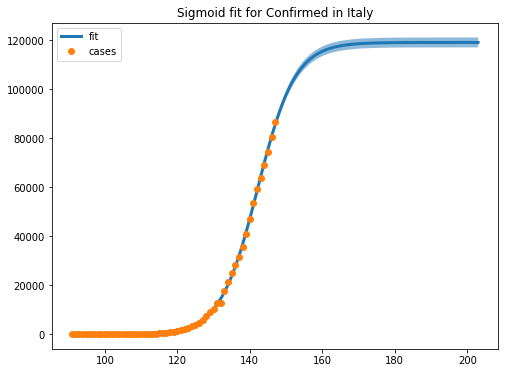

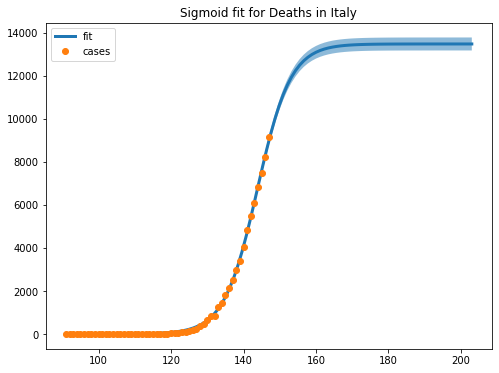

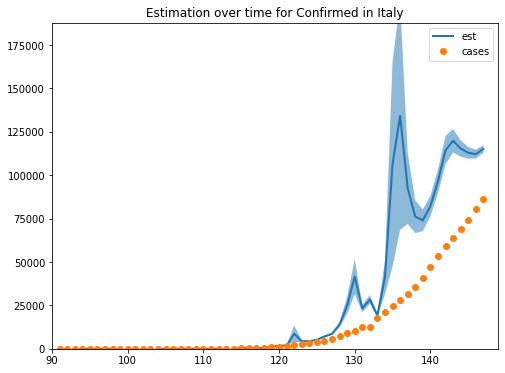

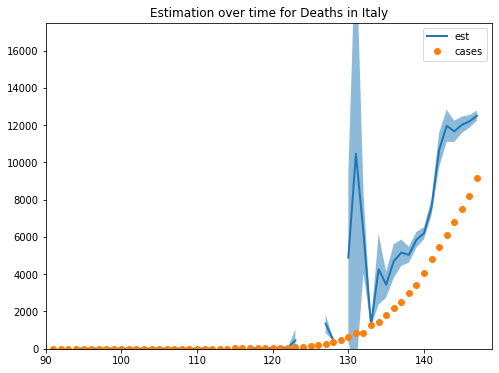

In [528]:
allPlots('Italy')


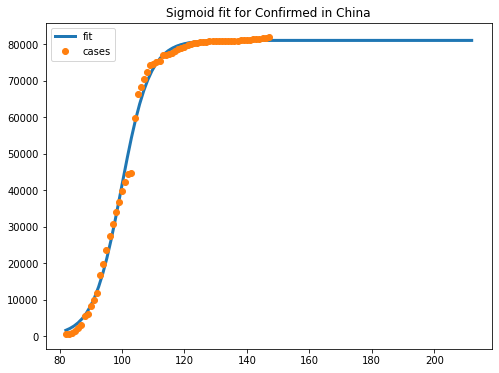

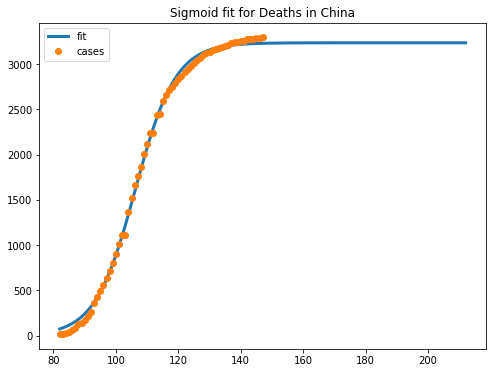

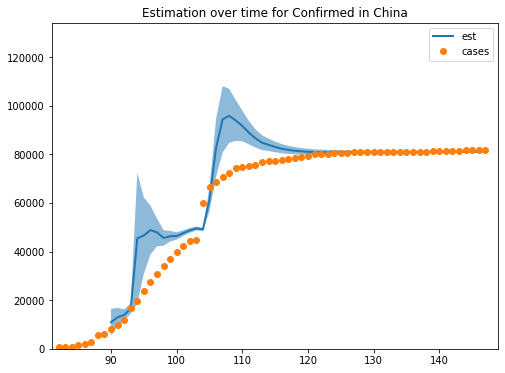

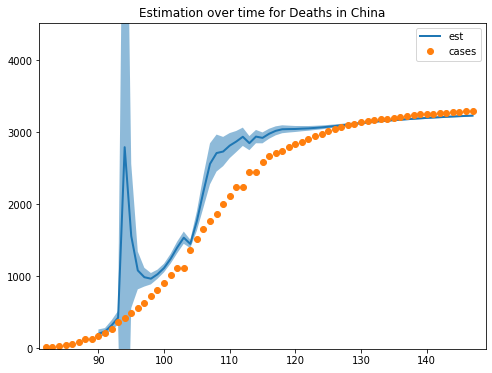

In [529]:
allPlots('China')

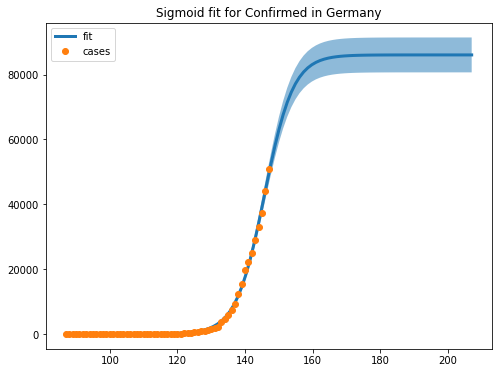

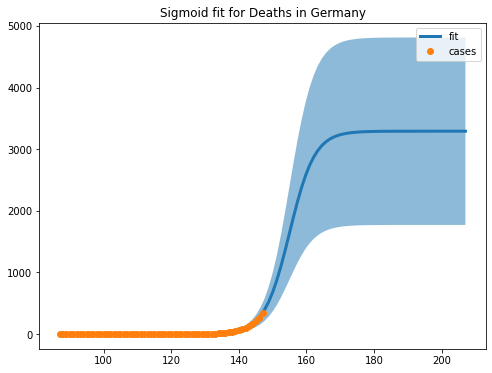

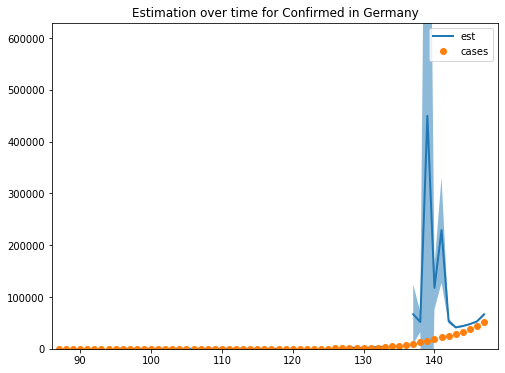

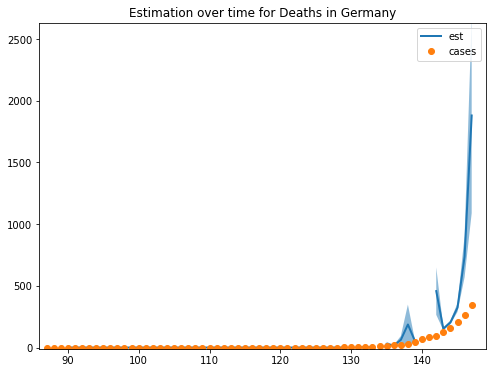

In [530]:
allPlots('Germany')

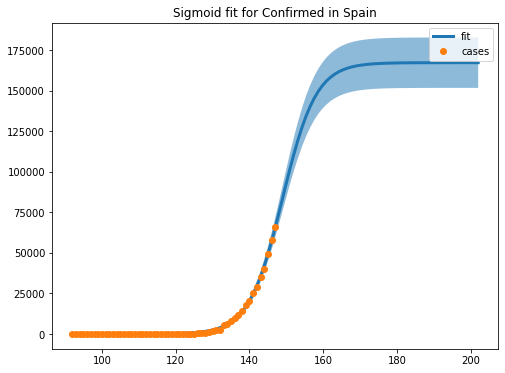

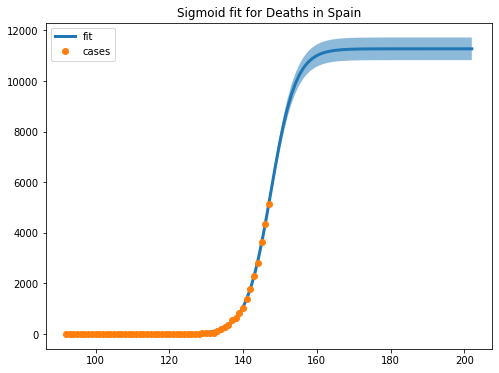

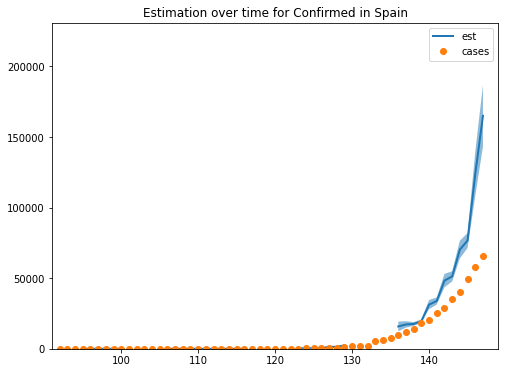

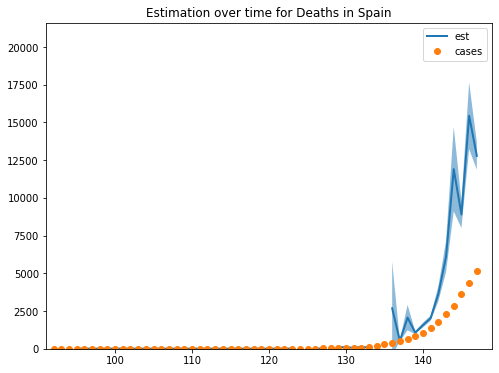

In [531]:
allPlots('Spain')

In [532]:
countries = ts['Country/Region'].unique()

In [533]:
cEst = {}

cIt,cItErr = estimate('Italy')

for c in countries:
    pcov, perr = estimate(c)
    if not np.isnan(pcov[0]):
        cEst[c]=[ pcov[0], pcov[1], pcov[2], pcov[0]-cIt[0] ]

cEstimates = pd.DataFrame.from_dict(cEst, columns=['dayOffset','speed','estMax','delay2Italy'], orient='index')

In [534]:
def plotCountries(countries, metric='Confirmed'):
    try:
        plt.figure(1, figsize=(8, 6))
        plt.clf()
        plt.title('Compare countries with offset')

        for c in countries:
            delay=int(cEst[c][3])
            yM=cEst[c][2]
            x,y=countryData(c, metric)
            plt.plot(x-delay, y/yM, linewidth=2.0, label=c+ ' (' +str(delay)+ ' days, max '+str(int(yM/1000))+'k)')

        plt.legend(loc='best')
        plt.show()
    except:
        print('No fit for '+metric+' in '+country)

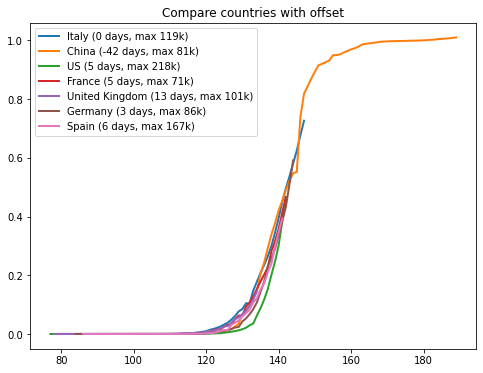

In [535]:
plotCountries(['Italy','China','US','France','United Kingdom','Germany','Spain'])